In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numpy as np
import random
import holidays
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

C:\Users\alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    # Renomeia as colunas
    df = df.rename(columns={'data': 'ds', 'valor': 'y'})
    return df

# Leitura dos dados tratados

In [3]:
def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

In [4]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)

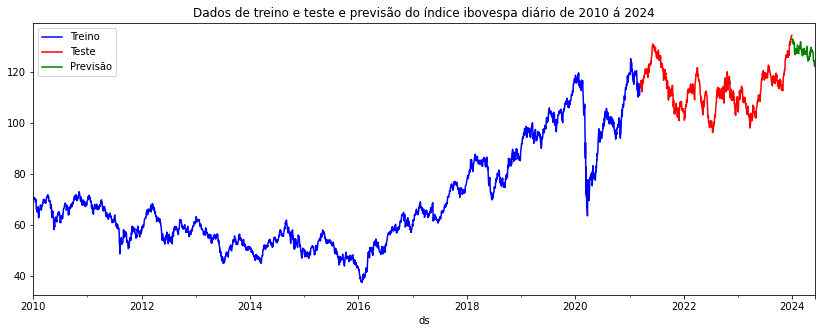

In [5]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
treino.plot(kind='line', x='ds', y='y', color='blue', label='Treino', ax=ax)
teste.plot(kind='line', x='ds', y='y', color='red', label='Teste', ax=ax)
previsao.plot(kind='line', x='ds', y='y', color='green', label='Previsão', ax=ax)
plt.title('Dados de treino e teste e previsão do índice ibovespa diário de 2010 á 2024')
plt.show()

# Ajuste de hiperparâmetros

In [6]:
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,10,20],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [7]:


# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil


In [31]:

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino)
    train_forecast = train_model.make_future_dataframe(periods=len(teste), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


00:16:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.322134044361734
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.737277316091557
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:14 - cmdstanpy - INFO - Chain [1] start processing
00:17:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.376520011488845
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.763364314036943
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:37 - cmdstanpy - INFO - Chain [1] start processing
00:17:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.358841832283465
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:43 - cmdstanpy - INFO - Chain [1] start processing
00:17:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.626210411251964
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:17:52 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.379238897827253
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.636314500407778
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.274463939314755
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:20 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.75286679790066
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.463905080584356
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.594780955412343
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:38 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.345330465681709
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:48 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.811841234600537
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.361281857122332
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:05 - cmdstanpy - INFO - Chain [1] start processing
00:19:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.645884238990936
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.32226061102121
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:21 - cmdstanpy - INFO - Chain [1] start processing
00:19:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.743765292305941
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:30 - cmdstanpy - INFO - Chain [1] start processing
00:19:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.348525214017718
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:34 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.753183351842994
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.354610295176062
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.748360048042496
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.378131672428152
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:11 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.6508949495877
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:21 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.492266523015164
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.55204522613904
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:47 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.517089671613103
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.62547586845019
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.54319460044658
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.5731079337155
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.531448556555773
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.640935488934215
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:22:39 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.467453553039032
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:22:47 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.541111122023775
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.60193687697444
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:23:10 - cmdstanpy - INFO - Chain [1] start processing
00:23:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.664203610368386
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:23:32 - cmdstanpy - INFO - Chain [1] start processing
00:23:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.55496753144391
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.648364673545007
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.49142012161236
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.577731558809546
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:24:49 - cmdstanpy - INFO - Chain [1] start processing
00:24:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.445521870000466
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:24:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.638133426016434
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:25:14 - cmdstanpy - INFO - Chain [1] start processing
00:25:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.492275582959813
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:25:18 - cmdstanpy - INFO - Chain [1] start processing
00:25:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.642841269851452
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.525297341847928
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:26:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.582027434544074
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.5718795477554
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:26:33 - cmdstanpy - INFO - Chain [1] start processing
00:26:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.656930109792324
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.904327900263192
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.355143587089552
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.826908678397647
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.385658242356818
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:28:10 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.725960762562075
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:29:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419993085891514
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:29:03 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.953599152649433
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:29:12 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.440900306054408
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:30:08 - cmdstanpy - INFO - Chain [1] start processing
00:30:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.866718773648184
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:30:15 - cmdstanpy - INFO - Chain [1] start processing
00:30:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.445957402359916
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.832806024043196
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:31:01 - cmdstanpy - INFO - Chain [1] start processing
00:31:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.434180545490634
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.00947366533596
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:31:49 - cmdstanpy - INFO - Chain [1] start processing
00:32:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.382637037820437
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.84079906116583
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:32:45 - cmdstanpy - INFO - Chain [1] start processing
00:33:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.434591964112903
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:33:36 - cmdstanpy - INFO - Chain [1] start processing
00:33:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.897885290125451
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:33:43 - cmdstanpy - INFO - Chain [1] start processing
00:34:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.435149093230434
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:34:20 - cmdstanpy - INFO - Chain [1] start processing
00:34:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.905558696417895
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:34:26 - cmdstanpy - INFO - Chain [1] start processing
00:35:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.462627719883143
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:35:11 - cmdstanpy - INFO - Chain [1] start processing
00:35:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.719454335868553
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:35:19 - cmdstanpy - INFO - Chain [1] start processing
00:36:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419130840436996
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:36:16 - cmdstanpy - INFO - Chain [1] start processing
00:36:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.008588237254394
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
00:37:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.56699130399742
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:37:24 - cmdstanpy - INFO - Chain [1] start processing
00:37:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.282245996400059
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:37:37 - cmdstanpy - INFO - Chain [1] start processing
00:38:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.49939196582238
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:38:16 - cmdstanpy - INFO - Chain [1] start processing
00:38:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.211385440222731
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:38:29 - cmdstanpy - INFO - Chain [1] start processing
00:39:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.43762083450127
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:39:14 - cmdstanpy - INFO - Chain [1] start processing
00:39:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.20952735622003
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:39:25 - cmdstanpy - INFO - Chain [1] start processing
00:39:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.398820284471945
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:40:03 - cmdstanpy - INFO - Chain [1] start processing
00:40:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.197408617940825
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:40:15 - cmdstanpy - INFO - Chain [1] start processing
00:40:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.304720702030796
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:40:46 - cmdstanpy - INFO - Chain [1] start processing
00:40:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.26118247926276
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:40:58 - cmdstanpy - INFO - Chain [1] start processing
00:41:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.550828032003945
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:41:19 - cmdstanpy - INFO - Chain [1] start processing
00:41:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.218991148306252
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:41:32 - cmdstanpy - INFO - Chain [1] start processing
00:41:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.384394287847876
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:41:55 - cmdstanpy - INFO - Chain [1] start processing
00:42:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.213811553657472
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:42:08 - cmdstanpy - INFO - Chain [1] start processing
00:42:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.400882869397684
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:42:42 - cmdstanpy - INFO - Chain [1] start processing
00:42:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.217396883180436
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:42:53 - cmdstanpy - INFO - Chain [1] start processing
00:43:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.38584153762934
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:43:32 - cmdstanpy - INFO - Chain [1] start processing
00:43:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.232853768552973
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:43:42 - cmdstanpy - INFO - Chain [1] start processing
00:44:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.494184051445703
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:44:13 - cmdstanpy - INFO - Chain [1] start processing
00:44:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.23057627986945
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:44:24 - cmdstanpy - INFO - Chain [1] start processing
00:44:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.421064155839318
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:44:50 - cmdstanpy - INFO - Chain [1] start processing
00:44:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.279607070081408
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:45:03 - cmdstanpy - INFO - Chain [1] start processing
00:45:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.39592712552534
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:45:38 - cmdstanpy - INFO - Chain [1] start processing
00:45:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.209079135456014
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:45:50 - cmdstanpy - INFO - Chain [1] start processing
00:46:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.414318537873093
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:46:25 - cmdstanpy - INFO - Chain [1] start processing
00:46:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.03739965765211
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:46:35 - cmdstanpy - INFO - Chain [1] start processing
00:47:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.605801976690877
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:47:10 - cmdstanpy - INFO - Chain [1] start processing
00:47:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.121558416079782
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:47:22 - cmdstanpy - INFO - Chain [1] start processing
00:48:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.611943149811562
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:48:13 - cmdstanpy - INFO - Chain [1] start processing
00:48:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.11224873961056
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:48:26 - cmdstanpy - INFO - Chain [1] start processing
00:49:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.63596759856587
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:49:21 - cmdstanpy - INFO - Chain [1] start processing
00:49:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.12902419346309
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:49:31 - cmdstanpy - INFO - Chain [1] start processing
00:50:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.65344297864428
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:50:24 - cmdstanpy - INFO - Chain [1] start processing
00:50:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.079616624399517
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:50:35 - cmdstanpy - INFO - Chain [1] start processing
00:50:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.645223949487853
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:50:57 - cmdstanpy - INFO - Chain [1] start processing
00:51:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.126663617998425
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:51:06 - cmdstanpy - INFO - Chain [1] start processing
00:51:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.60475852488601
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:51:42 - cmdstanpy - INFO - Chain [1] start processing
00:51:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.114344930383638
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:51:52 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.619873850311894
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:52:29 - cmdstanpy - INFO - Chain [1] start processing
00:52:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.1056766202715
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:52:44 - cmdstanpy - INFO - Chain [1] start processing
00:53:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.609828058022895
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:53:36 - cmdstanpy - INFO - Chain [1] start processing
00:53:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.088908632404248
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:53:46 - cmdstanpy - INFO - Chain [1] start processing
00:54:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.619917878930913
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:54:07 - cmdstanpy - INFO - Chain [1] start processing
00:54:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.119760924873958
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:54:18 - cmdstanpy - INFO - Chain [1] start processing
00:55:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.62760263172475
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:55:04 - cmdstanpy - INFO - Chain [1] start processing
00:55:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.113559890123106
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:55:16 - cmdstanpy - INFO - Chain [1] start processing
00:56:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.623698970363506
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:56:05 - cmdstanpy - INFO - Chain [1] start processing
00:56:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.090991881631098
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:56:15 - cmdstanpy - INFO - Chain [1] start processing
00:56:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.690258102795216
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:56:51 - cmdstanpy - INFO - Chain [1] start processing
00:56:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.915079005713222
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:57:00 - cmdstanpy - INFO - Chain [1] start processing
00:57:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.820758206743044
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:57:31 - cmdstanpy - INFO - Chain [1] start processing
00:57:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.886550639896969
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:57:47 - cmdstanpy - INFO - Chain [1] start processing
00:58:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.835762773968018
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:58:43 - cmdstanpy - INFO - Chain [1] start processing
00:58:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.966939617953587
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:58:55 - cmdstanpy - INFO - Chain [1] start processing
00:59:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.804039219459376
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:59:43 - cmdstanpy - INFO - Chain [1] start processing
00:59:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.961512707220939
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
00:59:58 - cmdstanpy - INFO - Chain [1] start processing
01:00:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.817062947761709
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:49 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.913898875348064
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:57 - cmdstanpy - INFO - Chain [1] start processing
01:01:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.81089544968779
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:32 - cmdstanpy - INFO - Chain [1] start processing
01:01:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.848150073367949
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:45 - cmdstanpy - INFO - Chain [1] start processing
01:02:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.915759437416938
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:27 - cmdstanpy - INFO - Chain [1] start processing
01:02:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.963184947774849
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:39 - cmdstanpy - INFO - Chain [1] start processing
01:03:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.90350652383208
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:28 - cmdstanpy - INFO - Chain [1] start processing
01:03:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.973867662362347
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:41 - cmdstanpy - INFO - Chain [1] start processing
01:04:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.885461196072862
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:04:28 - cmdstanpy - INFO - Chain [1] start processing
01:04:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.937495790521599
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:04:38 - cmdstanpy - INFO - Chain [1] start processing
01:05:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.863456803400963
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:05:13 - cmdstanpy - INFO - Chain [1] start processing
01:05:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.812741857185609
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:05:32 - cmdstanpy - INFO - Chain [1] start processing
01:06:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.033805585736829
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:06:28 - cmdstanpy - INFO - Chain [1] start processing
01:06:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.949651861099664
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:06:40 - cmdstanpy - INFO - Chain [1] start processing
01:07:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.80140608923363
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:07:35 - cmdstanpy - INFO - Chain [1] start processing
01:07:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.005952432611245
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:07:47 - cmdstanpy - INFO - Chain [1] start processing
01:08:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.837346907926236
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:08:38 - cmdstanpy - INFO - Chain [1] start processing
01:08:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.562006420334956
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:08:47 - cmdstanpy - INFO - Chain [1] start processing
01:08:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.81410375440021
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:09:01 - cmdstanpy - INFO - Chain [1] start processing
01:09:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.505599732454993
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:09:13 - cmdstanpy - INFO - Chain [1] start processing
01:09:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.7137268062213
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:09:34 - cmdstanpy - INFO - Chain [1] start processing
01:09:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.49438345623321
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:09:48 - cmdstanpy - INFO - Chain [1] start processing
01:10:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.680287861073467
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:10:24 - cmdstanpy - INFO - Chain [1] start processing
01:10:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.48555474372533
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:10:46 - cmdstanpy - INFO - Chain [1] start processing
01:11:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.511494286041692
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:11:17 - cmdstanpy - INFO - Chain [1] start processing
01:11:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.518306320397842
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:11:33 - cmdstanpy - INFO - Chain [1] start processing
01:11:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.624495959699193
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:11:54 - cmdstanpy - INFO - Chain [1] start processing
01:12:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.488423281446973
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:12:10 - cmdstanpy - INFO - Chain [1] start processing
01:12:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.490362604404467
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:12:26 - cmdstanpy - INFO - Chain [1] start processing
01:12:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.49529517978367
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:12:38 - cmdstanpy - INFO - Chain [1] start processing
01:12:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.55383825597637
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:12:51 - cmdstanpy - INFO - Chain [1] start processing
01:13:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.50011265754968
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:13:05 - cmdstanpy - INFO - Chain [1] start processing
01:13:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.51799747775731
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:13:25 - cmdstanpy - INFO - Chain [1] start processing
01:13:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.533971373305855
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:13:34 - cmdstanpy - INFO - Chain [1] start processing
01:13:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.879765625920605
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:13:52 - cmdstanpy - INFO - Chain [1] start processing
01:14:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.511165454346532
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:14:10 - cmdstanpy - INFO - Chain [1] start processing
01:14:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.69536540706639
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:14:30 - cmdstanpy - INFO - Chain [1] start processing
01:14:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.496534479590935
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:14:43 - cmdstanpy - INFO - Chain [1] start processing
01:15:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.776723228033287
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:15:18 - cmdstanpy - INFO - Chain [1] start processing
01:15:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.50047160412297
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:15:34 - cmdstanpy - INFO - Chain [1] start processing
01:16:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.758847720415535
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.53340614971355
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:16:22 - cmdstanpy - INFO - Chain [1] start processing
01:16:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.51637214226819
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:16:54 - cmdstanpy - INFO - Chain [1] start processing
01:17:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.57817233904363
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:17:13 - cmdstanpy - INFO - Chain [1] start processing
01:17:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.601178641672163
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:17:57 - cmdstanpy - INFO - Chain [1] start processing
01:18:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.563906000832258
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:18:13 - cmdstanpy - INFO - Chain [1] start processing
01:18:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.609453449585782
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:18:58 - cmdstanpy - INFO - Chain [1] start processing
01:19:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.541537890593414
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:19:25 - cmdstanpy - INFO - Chain [1] start processing
01:19:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.617800529827722
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:20:02 - cmdstanpy - INFO - Chain [1] start processing
01:20:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.54969136480209
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:20:14 - cmdstanpy - INFO - Chain [1] start processing
01:20:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.578401494325583
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:20:38 - cmdstanpy - INFO - Chain [1] start processing
01:20:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.56170092827369
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:20:54 - cmdstanpy - INFO - Chain [1] start processing
01:21:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.604595821850346
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:21:27 - cmdstanpy - INFO - Chain [1] start processing
01:21:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.56854551676982
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:21:42 - cmdstanpy - INFO - Chain [1] start processing
01:22:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.590232805564327
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:22:03 - cmdstanpy - INFO - Chain [1] start processing
01:22:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.557742548315204
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:22:31 - cmdstanpy - INFO - Chain [1] start processing
01:22:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.607397678629255
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:23:03 - cmdstanpy - INFO - Chain [1] start processing
01:23:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.547080247936528
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:23:17 - cmdstanpy - INFO - Chain [1] start processing
01:23:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.579338905350667
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:23:45 - cmdstanpy - INFO - Chain [1] start processing
01:23:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.57082352037233
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:24:00 - cmdstanpy - INFO - Chain [1] start processing
01:24:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.564944319053005
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:24:36 - cmdstanpy - INFO - Chain [1] start processing
01:24:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.53608522057974
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:24:54 - cmdstanpy - INFO - Chain [1] start processing
01:25:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.59476273531231
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:25:30 - cmdstanpy - INFO - Chain [1] start processing
01:25:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.589747319404317
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:25:45 - cmdstanpy - INFO - Chain [1] start processing
01:26:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.489955306347934
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:26:35 - cmdstanpy - INFO - Chain [1] start processing
01:26:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.362046498826613
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:26:46 - cmdstanpy - INFO - Chain [1] start processing
01:27:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.977560742930262
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:27:18 - cmdstanpy - INFO - Chain [1] start processing
01:27:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.507437039866382
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:27:39 - cmdstanpy - INFO - Chain [1] start processing
01:28:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.163053457030976
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:28:19 - cmdstanpy - INFO - Chain [1] start processing
01:28:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.511394312258007
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:28:38 - cmdstanpy - INFO - Chain [1] start processing
01:29:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.038987143608953
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:29:24 - cmdstanpy - INFO - Chain [1] start processing
01:29:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.539839511756782
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:29:47 - cmdstanpy - INFO - Chain [1] start processing
01:30:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.028682569358596
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:30:37 - cmdstanpy - INFO - Chain [1] start processing
01:30:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.561641325267114
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:30:51 - cmdstanpy - INFO - Chain [1] start processing
01:31:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.073360444605504
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:31:14 - cmdstanpy - INFO - Chain [1] start processing
01:31:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.484116461133798
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:31:34 - cmdstanpy - INFO - Chain [1] start processing
01:32:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.242033052989719
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:32:17 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.532183391391074
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:32:39 - cmdstanpy - INFO - Chain [1] start processing
01:33:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.122945561617192
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:33:23 - cmdstanpy - INFO - Chain [1] start processing
01:33:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.454171421459092
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:33:42 - cmdstanpy - INFO - Chain [1] start processing
01:34:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.125546549738234
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:34:21 - cmdstanpy - INFO - Chain [1] start processing
01:34:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.465389950659372
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:34:31 - cmdstanpy - INFO - Chain [1] start processing
01:34:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.986538107583208
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:35:00 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.626210439709823
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:35:15 - cmdstanpy - INFO - Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.129079220946279
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:36:02 - cmdstanpy - INFO - Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.506270663786248
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
01:37:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.226122638363238
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:37:13 - cmdstanpy - INFO - Chain [1] start processing
01:37:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.546552214289353
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:37:34 - cmdstanpy - INFO - Chain [1] start processing
01:38:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.135222204545993
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\1801775564.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [34]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,11.362046,"{'changepoint_prior_scale': 0.08, 'changepoint...",9.748276,0.087453
1,11.382637,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.387214,0.083506
2,11.385658,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.394137,0.083574
3,11.419131,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.442211,0.084044
4,11.419993,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.420590,0.083773


In [35]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 11.362046498826613
MAE: 9.74827570373372
MAPE: 0.08745284219321625
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


In [22]:
data_inicio = previsao['ds'].iloc[0]
data_fim = previsao['ds'].iloc[-1]
future = train_model.make_future_dataframe(periods=0, freq='D', include_history=False)
future['ds'] = pd.date_range(start=data_inicio, end=data_fim)

In [23]:
previsto = train_model.predict(future)

In [24]:
treino_concat = pd.concat([treino, teste])
previsao_concat = pd.concat([previsao])

In [36]:
train_model =Prophet(changepoint_prior_scale = parameters.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(previsao_concat), freq='D',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao=train_forecast[['ds','yhat']]
Actual = previsao
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])

07:49:55 - cmdstanpy - INFO - Chain [1] start processing
07:50:24 - cmdstanpy - INFO - Chain [1] done processing


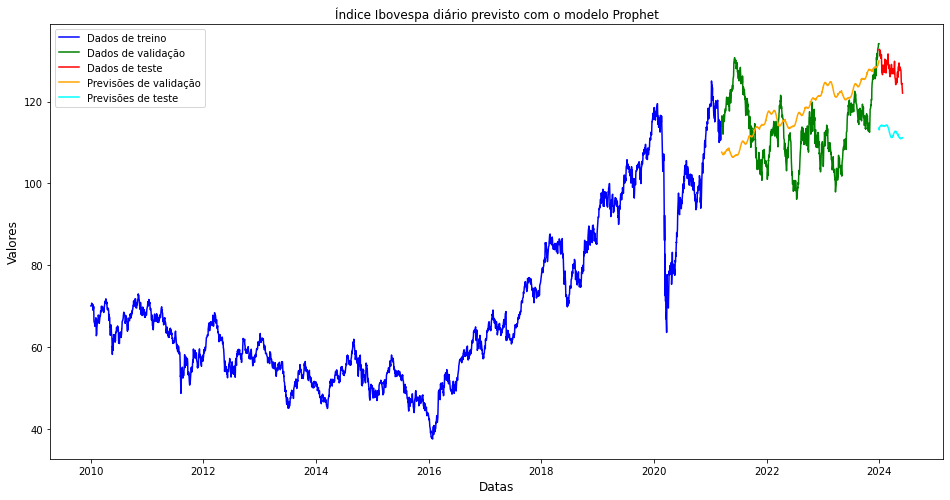

In [37]:
plt.figure(figsize=(16, 8))

plt.plot(treino['ds'], treino['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
plt.plot(teste['ds'],best_prediction['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

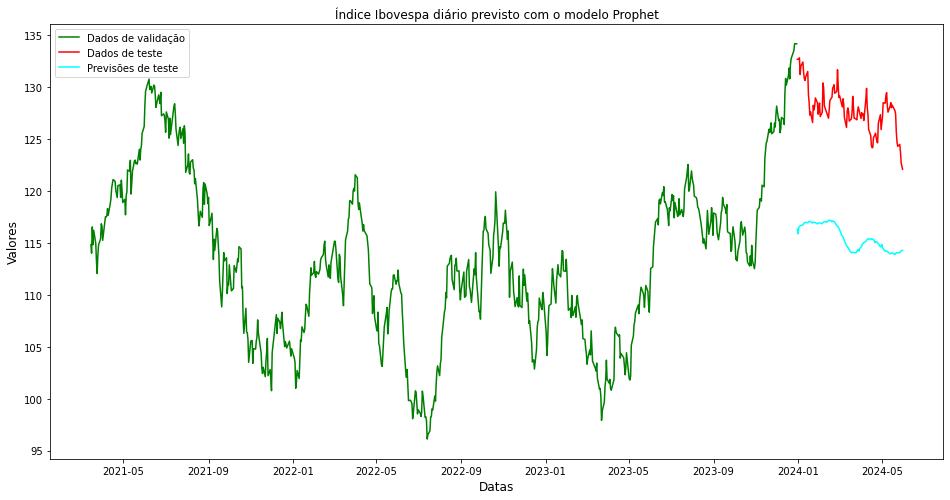

In [28]:
plt.figure(figsize=(16, 8))

#plt.plot(treino['ds'], treino['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
#plt.plot(teste['ds'],best_prediction['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [29]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)
print(parameters.loc[0, 'Parameters'])

RMSE: 12.472543877948807
MAE: 12.340518539477303
MAPE: 0.09633358654905459
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


# Eliminando dados irregulares da pandemia

In [38]:
treino1  = treino.loc['2016-01-01':'2020-02-01']
treino2 = treino.loc['2020-07-02':]

In [39]:
# Defina o intervalo de datas
data_inicio = '2020-02-02'
data_fim = '2020-07-01'

# Crie as datas dentro do intervalo
datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Gere valores entre 110 e 120
valores = np.linspace(117.597180, 96.234960, num=len(datas))

# Crie um DataFrame com as datas e valores
dados_pand = pd.DataFrame({'ds': datas, 'y': valores})
dados_pand.index = dados_pand['ds']
#dados_pand.drop('ds', axis=1, inplace=True)

In [40]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])

In [41]:

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino_sem_pand)
    train_forecast = train_model.make_future_dataframe(periods=len(teste), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


07:50:55 - cmdstanpy - INFO - Chain [1] start processing
07:50:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.753030184184574
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:50:59 - cmdstanpy - INFO - Chain [1] start processing
07:51:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.031598988827795
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:02 - cmdstanpy - INFO - Chain [1] start processing
07:51:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.845705690244888
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:04 - cmdstanpy - INFO - Chain [1] start processing
07:51:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.108124047654442
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:08 - cmdstanpy - INFO - Chain [1] start processing
07:51:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.798467982614273
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:12 - cmdstanpy - INFO - Chain [1] start processing
07:51:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.126796266127258
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:16 - cmdstanpy - INFO - Chain [1] start processing
07:51:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.7729758867494
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:20 - cmdstanpy - INFO - Chain [1] start processing
07:51:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.193290630971763
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:24 - cmdstanpy - INFO - Chain [1] start processing
07:51:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.78252771766579
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:26 - cmdstanpy - INFO - Chain [1] start processing
07:51:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.1176802943781
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:31 - cmdstanpy - INFO - Chain [1] start processing
07:51:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.54765821271147
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:33 - cmdstanpy - INFO - Chain [1] start processing
07:51:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.989263582550006
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:36 - cmdstanpy - INFO - Chain [1] start processing
07:51:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.90495757811872
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:37 - cmdstanpy - INFO - Chain [1] start processing
07:51:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.91129288518861
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:44 - cmdstanpy - INFO - Chain [1] start processing
07:51:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.864022511824263
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:46 - cmdstanpy - INFO - Chain [1] start processing
07:51:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.115934700125692
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:53 - cmdstanpy - INFO - Chain [1] start processing
07:51:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.818977304022145
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:57 - cmdstanpy - INFO - Chain [1] start processing
07:51:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.989248863622866
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:51:59 - cmdstanpy - INFO - Chain [1] start processing
07:52:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.884916838193885
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:01 - cmdstanpy - INFO - Chain [1] start processing
07:52:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.028796820586564
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:06 - cmdstanpy - INFO - Chain [1] start processing
07:52:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.783672832791282
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:08 - cmdstanpy - INFO - Chain [1] start processing
07:52:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.22634056884894
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:10 - cmdstanpy - INFO - Chain [1] start processing
07:52:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.816393963698303
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:15 - cmdstanpy - INFO - Chain [1] start processing
07:52:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.646805059237952
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:18 - cmdstanpy - INFO - Chain [1] start processing
07:52:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.065741910289255
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:19 - cmdstanpy - INFO - Chain [1] start processing
07:52:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.680901410534702
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:24 - cmdstanpy - INFO - Chain [1] start processing
07:52:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.53772873196696
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:28 - cmdstanpy - INFO - Chain [1] start processing
07:52:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.162244848813762
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:41 - cmdstanpy - INFO - Chain [1] start processing
07:52:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 16.934589534279365
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:43 - cmdstanpy - INFO - Chain [1] start processing
07:52:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.207549119782781
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:52:58 - cmdstanpy - INFO - Chain [1] start processing
07:52:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.430789434672178
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:00 - cmdstanpy - INFO - Chain [1] start processing
07:53:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.325854527783086
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:18 - cmdstanpy - INFO - Chain [1] start processing
07:53:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.073240771749916
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:20 - cmdstanpy - INFO - Chain [1] start processing
07:53:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.011116804842999
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:30 - cmdstanpy - INFO - Chain [1] start processing
07:53:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.328984276213728
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:31 - cmdstanpy - INFO - Chain [1] start processing
07:53:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.301199333548968
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:42 - cmdstanpy - INFO - Chain [1] start processing
07:53:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.58448572987271
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:45 - cmdstanpy - INFO - Chain [1] start processing
07:53:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.40470404093027
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:53:56 - cmdstanpy - INFO - Chain [1] start processing
07:53:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.24089419805559
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:00 - cmdstanpy - INFO - Chain [1] start processing
07:54:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.440004224739678
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:10 - cmdstanpy - INFO - Chain [1] start processing
07:54:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.246130733582593
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:14 - cmdstanpy - INFO - Chain [1] start processing
07:54:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.06360855168733
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:25 - cmdstanpy - INFO - Chain [1] start processing
07:54:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.49228517366345
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:29 - cmdstanpy - INFO - Chain [1] start processing
07:54:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.231490311332848
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:45 - cmdstanpy - INFO - Chain [1] start processing
07:54:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.42943901844027
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:54:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.384081681907372
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:05 - cmdstanpy - INFO - Chain [1] start processing
07:55:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.410910676995567
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:11 - cmdstanpy - INFO - Chain [1] start processing
07:55:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.472178995928132
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:37 - cmdstanpy - INFO - Chain [1] start processing
07:55:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.51215416090996
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:55:42 - cmdstanpy - INFO - Chain [1] start processing
07:56:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.329092258484916
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:05 - cmdstanpy - INFO - Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.492355444136054
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:14 - cmdstanpy - INFO - Chain [1] start processing
07:56:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.389802971060776
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:45 - cmdstanpy - INFO - Chain [1] start processing
07:56:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.38839762469644
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:56:50 - cmdstanpy - INFO - Chain [1] start processing
07:57:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.384163206879053
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:20 - cmdstanpy - INFO - Chain [1] start processing
07:57:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.334915722356596
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:22 - cmdstanpy - INFO - Chain [1] start processing
07:57:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.346407657285885
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:40 - cmdstanpy - INFO - Chain [1] start processing
07:57:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.414033851656782
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:41 - cmdstanpy - INFO - Chain [1] start processing
07:57:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.380268339329321
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:57:57 - cmdstanpy - INFO - Chain [1] start processing
07:58:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.491610917880498
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:02 - cmdstanpy - INFO - Chain [1] start processing
07:58:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.350781801875938
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:17 - cmdstanpy - INFO - Chain [1] start processing
07:58:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.243455970715594
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:21 - cmdstanpy - INFO - Chain [1] start processing
07:58:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.340648161699919
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:46 - cmdstanpy - INFO - Chain [1] start processing
07:58:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.534683241433946
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:58:50 - cmdstanpy - INFO - Chain [1] start processing
07:59:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.391307570135469
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:07 - cmdstanpy - INFO - Chain [1] start processing
07:59:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.606417822534693
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:11 - cmdstanpy - INFO - Chain [1] start processing
07:59:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.322263423527678
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
07:59:26 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.450268744972911
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
07:59:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.360553084974214
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:40 - cmdstanpy - INFO - Chain [1] start processing
07:59:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.380786580963987
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:43 - cmdstanpy - INFO - Chain [1] start processing
07:59:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.091545291016912
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:55 - cmdstanpy - INFO - Chain [1] start processing
07:59:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 10.314829153137879
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
07:59:59 - cmdstanpy - INFO - Chain [1] start processing
08:00:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.379329142149382
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:15 - cmdstanpy - INFO - Chain [1] start processing
08:00:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.04280062683927
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:17 - cmdstanpy - INFO - Chain [1] start processing
08:00:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.469321549684395
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:27 - cmdstanpy - INFO - Chain [1] start processing
08:00:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.06695528067517
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:30 - cmdstanpy - INFO - Chain [1] start processing
08:00:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.461348442166692
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:41 - cmdstanpy - INFO - Chain [1] start processing
08:00:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.046260018786477
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:00:47 - cmdstanpy - INFO - Chain [1] start processing
08:01:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.47038275729045
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:04 - cmdstanpy - INFO - Chain [1] start processing
08:01:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.06485249894315
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:12 - cmdstanpy - INFO - Chain [1] start processing
08:01:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.528432133597452
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:23 - cmdstanpy - INFO - Chain [1] start processing
08:01:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.01286365514505
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:28 - cmdstanpy - INFO - Chain [1] start processing
08:01:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.46822827942074
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:36 - cmdstanpy - INFO - Chain [1] start processing
08:01:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.045747270055518
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:40 - cmdstanpy - INFO - Chain [1] start processing
08:01:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.44859748426679
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:56 - cmdstanpy - INFO - Chain [1] start processing
08:01:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.037399942259054
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:01:59 - cmdstanpy - INFO - Chain [1] start processing
08:02:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.500073329892572
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:11 - cmdstanpy - INFO - Chain [1] start processing
08:02:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.04524375328445
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:17 - cmdstanpy - INFO - Chain [1] start processing
08:02:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.493387470030438
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:29 - cmdstanpy - INFO - Chain [1] start processing
08:02:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.05856410907191
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:32 - cmdstanpy - INFO - Chain [1] start processing
08:02:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.481796137148564
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:39 - cmdstanpy - INFO - Chain [1] start processing
08:02:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.064117600530285
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:44 - cmdstanpy - INFO - Chain [1] start processing
08:02:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.45330434867326
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:02:56 - cmdstanpy - INFO - Chain [1] start processing
08:02:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.048330258872898
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:00 - cmdstanpy - INFO - Chain [1] start processing
08:03:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.481539540123283
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:12 - cmdstanpy - INFO - Chain [1] start processing
08:03:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.050098531471967
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:18 - cmdstanpy - INFO - Chain [1] start processing
08:03:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.393483150595014
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:33 - cmdstanpy - INFO - Chain [1] start processing
08:03:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.492742840431399
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:36 - cmdstanpy - INFO - Chain [1] start processing
08:03:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.37637697497059
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:49 - cmdstanpy - INFO - Chain [1] start processing
08:03:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.581573894232044
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:03:53 - cmdstanpy - INFO - Chain [1] start processing
08:04:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.36545637027686
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:08 - cmdstanpy - INFO - Chain [1] start processing
08:04:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.631093281696613
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:12 - cmdstanpy - INFO - Chain [1] start processing
08:04:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.399608666857283
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:25 - cmdstanpy - INFO - Chain [1] start processing
08:04:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.67488471535393
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:30 - cmdstanpy - INFO - Chain [1] start processing
08:04:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.409388545475153
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:46 - cmdstanpy - INFO - Chain [1] start processing
08:04:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.545377393288307
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:04:50 - cmdstanpy - INFO - Chain [1] start processing
08:05:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.397655630844177
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:03 - cmdstanpy - INFO - Chain [1] start processing
08:05:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.660757220990517
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:06 - cmdstanpy - INFO - Chain [1] start processing
08:05:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.377939340708902
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:19 - cmdstanpy - INFO - Chain [1] start processing
08:05:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.662742946110374
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:26 - cmdstanpy - INFO - Chain [1] start processing
08:05:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.388411363958273
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:50 - cmdstanpy - INFO - Chain [1] start processing
08:05:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.667024487848693
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:05:56 - cmdstanpy - INFO - Chain [1] start processing
08:06:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.419152273970727
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:22 - cmdstanpy - INFO - Chain [1] start processing
08:06:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.494168521387474
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:25 - cmdstanpy - INFO - Chain [1] start processing
08:06:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.38559867520685
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:33 - cmdstanpy - INFO - Chain [1] start processing
08:06:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.697723805843916
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:39 - cmdstanpy - INFO - Chain [1] start processing
08:06:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.399260540025887
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:52 - cmdstanpy - INFO - Chain [1] start processing
08:06:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.698259461638786
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:06:56 - cmdstanpy - INFO - Chain [1] start processing
08:07:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.403124399341014
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:13 - cmdstanpy - INFO - Chain [1] start processing
08:07:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.682908226279809
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:19 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.401382265350485
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.135321453308649
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:43 - cmdstanpy - INFO - Chain [1] start processing
08:07:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.524953060746816
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:53 - cmdstanpy - INFO - Chain [1] start processing
08:07:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.161028630079265
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:07:59 - cmdstanpy - INFO - Chain [1] start processing
08:08:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.614471925224521
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:08:11 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.259619458479595
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:08:21 - cmdstanpy - INFO - Chain [1] start processing
08:08:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.646909648661302
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:08:38 - cmdstanpy - INFO - Chain [1] start processing
08:08:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.328635109158151
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:08:49 - cmdstanpy - INFO - Chain [1] start processing
08:09:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.56037001209993
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:09:08 - cmdstanpy - INFO - Chain [1] start processing
08:09:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.422032138905251
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:09:12 - cmdstanpy - INFO - Chain [1] start processing
08:09:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.843808580011284
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:09:23 - cmdstanpy - INFO - Chain [1] start processing
08:09:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.144273149943263
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:09:32 - cmdstanpy - INFO - Chain [1] start processing
08:09:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.710608922078467
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:10:02 - cmdstanpy - INFO - Chain [1] start processing
08:10:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.245194001953369
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:10:19 - cmdstanpy - INFO - Chain [1] start processing
08:10:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.627327450559925
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:10:45 - cmdstanpy - INFO - Chain [1] start processing
08:10:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.244784578631164
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:10:55 - cmdstanpy - INFO - Chain [1] start processing
08:11:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.660234650788107
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:11:21 - cmdstanpy - INFO - Chain [1] start processing
08:11:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.124813419350549
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:11:28 - cmdstanpy - INFO - Chain [1] start processing
08:11:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.620743692166203
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:11:48 - cmdstanpy - INFO - Chain [1] start processing
08:11:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.181857769096759
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:11:56 - cmdstanpy - INFO - Chain [1] start processing
08:12:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.704557950520933
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:12:10 - cmdstanpy - INFO - Chain [1] start processing
08:12:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.24267857565957
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:12:19 - cmdstanpy - INFO - Chain [1] start processing
08:12:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.610005208246088
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:12:38 - cmdstanpy - INFO - Chain [1] start processing
08:12:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.306803605191826
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:12:47 - cmdstanpy - INFO - Chain [1] start processing
08:13:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.560695053416627
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:06 - cmdstanpy - INFO - Chain [1] start processing
08:13:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.126168331821482
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:11 - cmdstanpy - INFO - Chain [1] start processing
08:13:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.155681676374535
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:26 - cmdstanpy - INFO - Chain [1] start processing
08:13:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.13681204391521
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:37 - cmdstanpy - INFO - Chain [1] start processing
08:13:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.192898522012417
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:44 - cmdstanpy - INFO - Chain [1] start processing
08:13:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.146976480499948
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:13:50 - cmdstanpy - INFO - Chain [1] start processing
08:14:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.192829526346085
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:03 - cmdstanpy - INFO - Chain [1] start processing
08:14:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.136625790710305
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:12 - cmdstanpy - INFO - Chain [1] start processing
08:14:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.10965023320252
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:21 - cmdstanpy - INFO - Chain [1] start processing
08:14:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.13462983382126
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:26 - cmdstanpy - INFO - Chain [1] start processing
08:14:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.16413522242106
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:37 - cmdstanpy - INFO - Chain [1] start processing
08:14:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.124769503186222
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:47 - cmdstanpy - INFO - Chain [1] start processing
08:14:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.242516284062667
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:54 - cmdstanpy - INFO - Chain [1] start processing
08:14:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.139612445097452
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:14:59 - cmdstanpy - INFO - Chain [1] start processing
08:15:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.207950614948174
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:08 - cmdstanpy - INFO - Chain [1] start processing
08:15:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.160424428725637
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:11 - cmdstanpy - INFO - Chain [1] start processing
08:15:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.19970234138216
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:16 - cmdstanpy - INFO - Chain [1] start processing
08:15:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.1172769066969
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:18 - cmdstanpy - INFO - Chain [1] start processing
08:15:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.235491828733515
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:20 - cmdstanpy - INFO - Chain [1] start processing
08:15:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.130103514502213
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:22 - cmdstanpy - INFO - Chain [1] start processing
08:15:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.12915005353973
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:25 - cmdstanpy - INFO - Chain [1] start processing
08:15:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.133868304519527
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:34 - cmdstanpy - INFO - Chain [1] start processing
08:15:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.229698395730086
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:39 - cmdstanpy - INFO - Chain [1] start processing
08:15:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.14137584285969
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:42 - cmdstanpy - INFO - Chain [1] start processing
08:15:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.151481440107847
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:48 - cmdstanpy - INFO - Chain [1] start processing
08:15:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.341996056082188
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:50 - cmdstanpy - INFO - Chain [1] start processing
08:15:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.356867989455102
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:54 - cmdstanpy - INFO - Chain [1] start processing
08:15:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.23460493985761
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:15:58 - cmdstanpy - INFO - Chain [1] start processing
08:16:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.347257692782676
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:03 - cmdstanpy - INFO - Chain [1] start processing
08:16:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.204474839291498
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:06 - cmdstanpy - INFO - Chain [1] start processing
08:16:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.343936601042394
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:18 - cmdstanpy - INFO - Chain [1] start processing
08:16:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.35791386680379
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:22 - cmdstanpy - INFO - Chain [1] start processing
08:16:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.341051587674837
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:28 - cmdstanpy - INFO - Chain [1] start processing
08:16:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.201946059424333
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:30 - cmdstanpy - INFO - Chain [1] start processing
08:16:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.355500029213504
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:35 - cmdstanpy - INFO - Chain [1] start processing
08:16:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.300741007336928
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:38 - cmdstanpy - INFO - Chain [1] start processing
08:16:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.336496826176932
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:44 - cmdstanpy - INFO - Chain [1] start processing
08:16:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.248194222755425
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:47 - cmdstanpy - INFO - Chain [1] start processing
08:16:56 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.336766908958353
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:16:56 - cmdstanpy - INFO - Chain [1] start processing
08:16:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.327384941446773
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:00 - cmdstanpy - INFO - Chain [1] start processing
08:17:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.348743504180375
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:04 - cmdstanpy - INFO - Chain [1] start processing
08:17:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.205644237669363
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:07 - cmdstanpy - INFO - Chain [1] start processing
08:17:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.355930886037806
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:11 - cmdstanpy - INFO - Chain [1] start processing
08:17:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.235808164504055
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:13 - cmdstanpy - INFO - Chain [1] start processing
08:17:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.337030180023627
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:18 - cmdstanpy - INFO - Chain [1] start processing
08:17:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.105457302901158
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:24 - cmdstanpy - INFO - Chain [1] start processing
08:17:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.345829908282157
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:32 - cmdstanpy - INFO - Chain [1] start processing
08:17:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.226880497259268
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:35 - cmdstanpy - INFO - Chain [1] start processing
08:17:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.333952459170765
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:42 - cmdstanpy - INFO - Chain [1] start processing
08:17:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.587832968162854
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:46 - cmdstanpy - INFO - Chain [1] start processing
08:17:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.701263184064183
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:50 - cmdstanpy - INFO - Chain [1] start processing
08:17:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.5755047394504
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:17:56 - cmdstanpy - INFO - Chain [1] start processing
08:18:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.839912896399653
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:18:06 - cmdstanpy - INFO - Chain [1] start processing
08:18:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.600454125016755
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:18:39 - cmdstanpy - INFO - Chain [1] start processing
08:18:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.609341984528722
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:18:55 - cmdstanpy - INFO - Chain [1] start processing
08:19:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.61445221709946
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:19:05 - cmdstanpy - INFO - Chain [1] start processing
08:19:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.623060994665304
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:19:12 - cmdstanpy - INFO - Chain [1] start processing
08:19:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.610278986555377
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:19:20 - cmdstanpy - INFO - Chain [1] start processing
08:19:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.698427840274535
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:19:42 - cmdstanpy - INFO - Chain [1] start processing
08:19:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.57984398121123
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:19:53 - cmdstanpy - INFO - Chain [1] start processing
08:20:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.842362109663645
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:04 - cmdstanpy - INFO - Chain [1] start processing
08:20:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.609895614673508
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:14 - cmdstanpy - INFO - Chain [1] start processing
08:20:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.546205597724216
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:27 - cmdstanpy - INFO - Chain [1] start processing
08:20:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.610946863648337
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:39 - cmdstanpy - INFO - Chain [1] start processing
08:20:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.899541924540237
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:47 - cmdstanpy - INFO - Chain [1] start processing
08:20:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.623678567310337
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:20:51 - cmdstanpy - INFO - Chain [1] start processing
08:21:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.69388972718781
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:02 - cmdstanpy - INFO - Chain [1] start processing
08:21:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.591543174588839
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:15 - cmdstanpy - INFO - Chain [1] start processing
08:21:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.772221946959165
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:21 - cmdstanpy - INFO - Chain [1] start processing
08:21:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.617184794183702
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:28 - cmdstanpy - INFO - Chain [1] start processing
08:21:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.738713858909314
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:39 - cmdstanpy - INFO - Chain [1] start processing
08:21:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.602296726487676
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
08:21:48 - cmdstanpy - INFO - Chain [1] start processing
08:21:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.809764939491433
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_34948\4250011204.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [50]:
parameters2 = model_parameters.sort_values(by=['RMSE'])
parameters2 = parameters.reset_index(drop=True)
parameters2.head()


,RMSE,Parameters,MAE,MAPE
0,11.362046,"{'changepoint_prior_scale': 0.08, 'changepoint...",9.748276,0.087453
1,11.382637,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.387214,0.083506
2,11.385658,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.394137,0.083574
3,11.419131,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.442211,0.084044
4,11.419993,"{'changepoint_prior_scale': 0.01, 'changepoint...",9.420590,0.083773


In [62]:

print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)
print(parameters2.loc[0, 'Parameters'])

RMSE: 6.659967395606669
MAE: 6.319088654277171
MAPE: 0.049167724721012065
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


In [55]:
treino_concat = pd.concat([treino_sem_pand, teste])
previsao_concat = pd.concat([previsao])

In [58]:
train_model =Prophet(changepoint_prior_scale = parameters2.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters2.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters2.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters2.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters2.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(previsao_concat), freq='D',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao2=train_forecast[['ds','yhat']]
Actual = previsao_concat
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao2['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao2['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao2['yhat'])

20:36:20 - cmdstanpy - INFO - Chain [1] start processing
20:36:26 - cmdstanpy - INFO - Chain [1] done processing


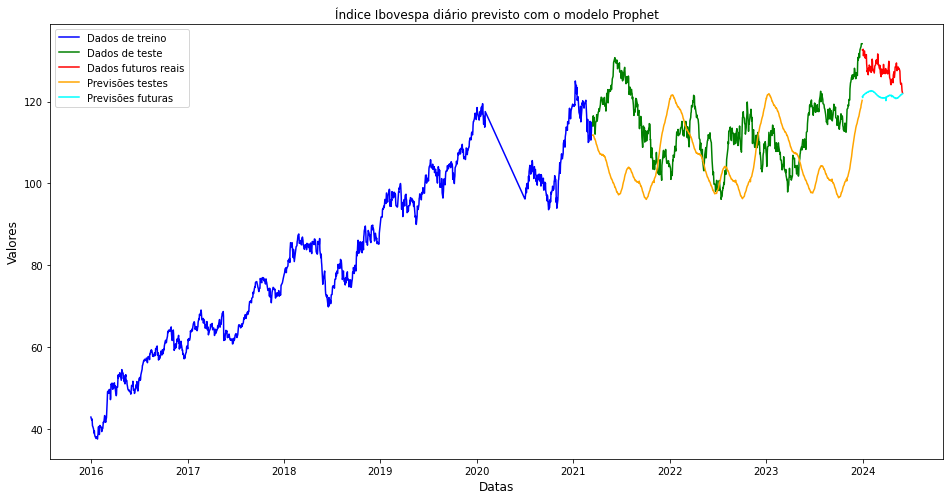

In [59]:
plt.figure(figsize=(16, 8))

plt.plot(treino_sem_pand['ds'], treino_sem_pand['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de teste')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados futuros reais')
plt.plot(teste['ds'],predicao['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao['ds'],predicao2['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

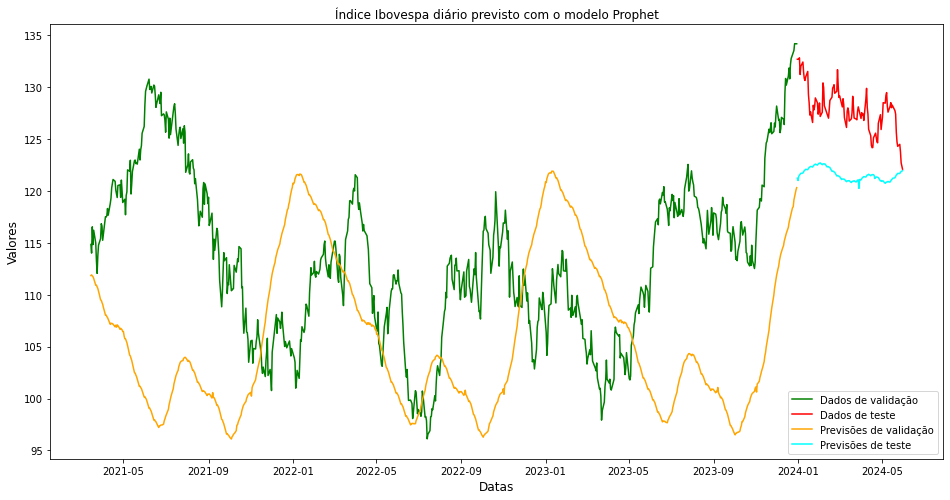

In [60]:
plt.figure(figsize=(16, 8))

#plt.plot(treino_sem_pand['ds'], treino_sem_pand['y'],color='blue', label='Dados de treino')
plt.plot(teste['ds'], teste['y'],color='green', label='Dados de validação')
plt.plot(previsao['ds'], previsao['y'],color='red', label='Dados de teste')
plt.plot(teste['ds'],predicao['yhat'],color='orange', label='Previsões de validação')
plt.plot(previsao['ds'],predicao2['yhat'],color='cyan', label='Previsões de teste')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [61]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)

RMSE: 6.659967395606669
MAE: 6.319088654277171
MAPE: 0.049167724721012065


# Série com dados mensais


In [6]:
treino_mensal = treino.copy()
teste_mensal = teste.copy()
previsao_mensal = previsao.copy()

In [7]:
treino_mensal = treino_mensal.resample('M', on='ds').mean()
teste_mensal = teste_mensal.resample('M', on='ds').mean()
previsao_mensal = previsao_mensal.resample('M', on='ds').mean()

In [8]:
treino_mensal['ds']=treino_mensal.index
teste_mensal['ds']=teste_mensal.index
previsao_mensal['ds']=previsao_mensal.index

In [9]:
treino_mensal

,y,ds
ds,,
2010-01-31,68.444684,2010-01-31
2010-02-28,65.985147,2010-02-28
2010-03-31,69.061235,2010-03-31
2010-04-30,69.889529,2010-04-30
2010-05-31,62.875233,2010-05-31
...,...,...
2020-11-30,104.818999,2020-11-30
2020-12-31,116.019003,2020-12-31
2021-01-31,119.721724,2021-01-31


In [10]:
params_grid = {'seasonality_mode':(['additive','multiplicative']),
               'changepoint_prior_scale':[0.01,0.04, 0.08],
              'holidays_prior_scale': [1,5,8],
               'changepoint_range':[0.4,0.6,0.8],
              'n_changepoints' : [2,5,10,15]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [15]:

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(treino_mensal)
    train_forecast = train_model.make_future_dataframe(periods=len(teste_mensal), freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = teste_mensal
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:00:15 - cmdstanpy - INFO - Chain [1] start processing
23:00:15 - cmdstanpy - INFO - Chain [1] done processing
23:00:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:15 - cmdstanpy - INFO - Chain [1] start processing
23:00:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.562447355555857


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing
23:00:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:22 - cmdstanpy - INFO - Chain [1] start processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 19.12205197713195
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing
23:00:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.552553132395097
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:00:35 - cmdstanpy - INFO - Chain [1] start processing
23:00:35 - cmdstanpy - INFO - Chain [1] done processing
23:00:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091298679
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:00:42 - cmdstanpy - INFO - Chain [1] start processing
23:00:42 - cmdstanpy - INFO - Chain [1] done processing
23:00:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:42 - cmdstanpy - INFO - Chain [1] start processing
23:00:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.552553132395097
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:00:47 - cmdstanpy - INFO - Chain [1] start processing
23:00:47 - cmdstanpy - INFO - Chain [1] done processing
23:00:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:47 - cmdstanpy - INFO - Chain [1] start processing
23:00:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091298679
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:00:50 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing
23:00:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:51 - cmdstanpy - INFO - Chain [1] start processing
23:00:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.552553132395097
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
23:00:58 - cmdstanpy - INFO - Chain [1] done processing
23:00:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
23:01:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091298679
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] done processing
23:01:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.56244776052452
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing
23:01:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:16 - cmdstanpy - INFO - Chain [1] start processing
23:01:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.122051978009054
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] done processing
23:01:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 18.552559263382935
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing
23:01:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:31 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091301349
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:32 - cmdstanpy - INFO - Chain [1] done processing
23:01:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.552559263382935
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing
23:01:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091301349
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:45 - cmdstanpy - INFO - Chain [1] start processing
23:01:45 - cmdstanpy - INFO - Chain [1] done processing
23:01:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:45 - cmdstanpy - INFO - Chain [1] start processing
23:01:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.552559263382935
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:50 - cmdstanpy - INFO - Chain [1] start processing
23:01:50 - cmdstanpy - INFO - Chain [1] done processing
23:01:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:50 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.08501091301349
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:53 - cmdstanpy - INFO - Chain [1] start processing
23:01:53 - cmdstanpy - INFO - Chain [1] done processing
23:01:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:53 - cmdstanpy - INFO - Chain [1] start processing
23:01:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.56242912540983
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:01:58 - cmdstanpy - INFO - Chain [1] start processing
23:01:58 - cmdstanpy - INFO - Chain [1] done processing
23:01:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:58 - cmdstanpy - INFO - Chain [1] start processing
23:02:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.122051976649843
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:01 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing
23:02:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:01 - cmdstanpy - INFO - Chain [1] start processing
23:02:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55255404788735
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:06 - cmdstanpy - INFO - Chain [1] start processing
23:02:06 - cmdstanpy - INFO - Chain [1] done processing
23:02:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:06 - cmdstanpy - INFO - Chain [1] start processing
23:02:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.085010912564282
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:12 - cmdstanpy - INFO - Chain [1] start processing
23:02:12 - cmdstanpy - INFO - Chain [1] done processing
23:02:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:12 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55255404788735
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:18 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing
23:02:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:18 - cmdstanpy - INFO - Chain [1] start processing
23:02:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.085010912564282
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:22 - cmdstanpy - INFO - Chain [1] start processing
23:02:22 - cmdstanpy - INFO - Chain [1] done processing
23:02:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:22 - cmdstanpy - INFO - Chain [1] start processing
23:02:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55255404788735
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:29 - cmdstanpy - INFO - Chain [1] start processing
23:02:29 - cmdstanpy - INFO - Chain [1] done processing
23:02:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:29 - cmdstanpy - INFO - Chain [1] start processing
23:02:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 19.085010912564282
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:02:32 - cmdstanpy - INFO - Chain [1] start processing
23:02:32 - cmdstanpy - INFO - Chain [1] done processing
23:02:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:32 - cmdstanpy - INFO - Chain [1] start processing
23:02:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.530121655050667
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:37 - cmdstanpy - INFO - Chain [1] start processing
23:02:37 - cmdstanpy - INFO - Chain [1] done processing
23:02:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:37 - cmdstanpy - INFO - Chain [1] start processing
23:02:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.128966427004933
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:43 - cmdstanpy - INFO - Chain [1] done processing
23:02:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 18.47983692847468
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:02:48 - cmdstanpy - INFO - Chain [1] done processing
23:02:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:48 - cmdstanpy - INFO - Chain [1] start processing
23:02:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.102997277661217
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:02:55 - cmdstanpy - INFO - Chain [1] start processing
23:02:55 - cmdstanpy - INFO - Chain [1] done processing
23:02:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:02:56 - cmdstanpy - INFO - Chain [1] start processing
23:03:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55146141759425
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:02 - cmdstanpy - INFO - Chain [1] start processing
23:03:02 - cmdstanpy - INFO - Chain [1] done processing
23:03:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:02 - cmdstanpy - INFO - Chain [1] start processing
23:03:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.144170630728798
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:10 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing
23:03:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:10 - cmdstanpy - INFO - Chain [1] start processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 18.55146141759425
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:03:16 - cmdstanpy - INFO - Chain [1] start processing
23:03:16 - cmdstanpy - INFO - Chain [1] done processing
23:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:16 - cmdstanpy - INFO - Chain [1] start processing
23:03:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.144170630728798
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:21 - cmdstanpy - INFO - Chain [1] start processing
23:03:21 - cmdstanpy - INFO - Chain [1] done processing
23:03:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:22 - cmdstanpy - INFO - Chain [1] start processing
23:03:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.530122908477814
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:28 - cmdstanpy - INFO - Chain [1] start processing
23:03:28 - cmdstanpy - INFO - Chain [1] done processing
23:03:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:28 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 19.128882374093955
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:31 - cmdstanpy - INFO - Chain [1] done processing
23:03:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:31 - cmdstanpy - INFO - Chain [1] start processing
23:03:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.479837962609665
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:41 - cmdstanpy - INFO - Chain [1] done processing
23:03:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.102997277671765
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55146343676779
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:04:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 19.14417063080695
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:04:00 - cmdstanpy - INFO - Chain [1] start processing
23:04:00 - cmdstanpy - INFO - Chain [1] done processing
23:04:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:00 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55146343676779
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:09 - cmdstanpy - INFO - Chain [1] start processing
23:04:09 - cmdstanpy - INFO - Chain [1] done processing
23:04:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:09 - cmdstanpy - INFO - Chain [1] start processing
23:04:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 19.14417063080695
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:13 - cmdstanpy - INFO - Chain [1] done processing
23:04:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.53012313833693
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:18 - cmdstanpy - INFO - Chain [1] done processing
23:04:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.128924905578252
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:24 - cmdstanpy - INFO - Chain [1] start processing
23:04:24 - cmdstanpy - INFO - Chain [1] done processing
23:04:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:24 - cmdstanpy - INFO - Chain [1] start processing
23:04:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.47983705091119
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:30 - cmdstanpy - INFO - Chain [1] start processing
23:04:30 - cmdstanpy - INFO - Chain [1] done processing
23:04:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:30 - cmdstanpy - INFO - Chain [1] start processing
23:04:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.10299727769048
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:36 - cmdstanpy - INFO - Chain [1] start processing
23:04:36 - cmdstanpy - INFO - Chain [1] done processing
23:04:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:37 - cmdstanpy - INFO - Chain [1] start processing
23:04:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.55147636344274
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:43 - cmdstanpy - INFO - Chain [1] start processing
23:04:43 - cmdstanpy - INFO - Chain [1] done processing
23:04:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:43 - cmdstanpy - INFO - Chain [1] start processing
23:04:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.144170630695875
total:  21.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:04:50 - cmdstanpy - INFO - Chain [1] start processing
23:04:50 - cmdstanpy - INFO - Chain [1] done processing
23:04:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:50 - cmdstanpy - INFO - Chain [1] start processing
23:04:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 18.55147636344274
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:04:58 - cmdstanpy - INFO - Chain [1] start processing
23:04:58 - cmdstanpy - INFO - Chain [1] done processing
23:04:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:04:58 - cmdstanpy - INFO - Chain [1] start processing
23:05:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.144170630695875
total:  22.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:03 - cmdstanpy - INFO - Chain [1] start processing
23:05:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.483551886823147
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:05 - cmdstanpy - INFO - Chain [1] start processing
23:05:05 - cmdstanpy - INFO - Chain [1] done processing
23:05:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:05 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.07441893270768
total:  23.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:10 - cmdstanpy - INFO - Chain [1] start processing
23:05:10 - cmdstanpy - INFO - Chain [1] done processing
23:05:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:10 - cmdstanpy - INFO - Chain [1] start processing
23:05:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.585014374211774
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:18 - cmdstanpy - INFO - Chain [1] done processing
23:05:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.040368407747465
total:  24.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:27 - cmdstanpy - INFO - Chain [1] start processing
23:05:27 - cmdstanpy - INFO - Chain [1] done processing
23:05:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:27 - cmdstanpy - INFO - Chain [1] start processing
23:05:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.58896370421394
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:46 - cmdstanpy - INFO - Chain [1] start processing
23:05:46 - cmdstanpy - INFO - Chain [1] done processing
23:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:46 - cmdstanpy - INFO - Chain [1] start processing
23:05:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.133074653787776
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:05:57 - cmdstanpy - INFO - Chain [1] start processing
23:05:57 - cmdstanpy - INFO - Chain [1] done processing
23:05:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:05:57 - cmdstanpy - INFO - Chain [1] start processing
23:06:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.570246280583866
total:  25.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:06:11 - cmdstanpy - INFO - Chain [1] start processing
23:06:12 - cmdstanpy - INFO - Chain [1] done processing
23:06:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:06:12 - cmdstanpy - INFO - Chain [1] start processing
23:06:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.12127238028566
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:06:27 - cmdstanpy - INFO - Chain [1] start processing
23:06:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.483551886823147
total:  26.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:06:28 - cmdstanpy - INFO - Chain [1] start processing
23:06:29 - cmdstanpy - INFO - Chain [1] done processing
23:06:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:06:29 - cmdstanpy - INFO - Chain [1] start processing
23:06:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.074418932643404
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:06:35 - cmdstanpy - INFO - Chain [1] start processing
23:06:35 - cmdstanpy - INFO - Chain [1] done processing
23:06:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:06:35 - cmdstanpy - INFO - Chain [1] start processing
23:06:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.585042404188403
total:  27.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:06:50 - cmdstanpy - INFO - Chain [1] start processing
23:06:51 - cmdstanpy - INFO - Chain [1] done processing
23:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:06:51 - cmdstanpy - INFO - Chain [1] start processing
23:06:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.04036871960879
total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:00 - cmdstanpy - INFO - Chain [1] start processing
23:07:00 - cmdstanpy - INFO - Chain [1] done processing
23:07:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:00 - cmdstanpy - INFO - Chain [1] start processing
23:07:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.588961861162957


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  28.000000000000004
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:07:20 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing
23:07:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:20 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.133074653782646
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.57025565277023
total:  28.999999999999996
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:43 - cmdstanpy - INFO - Chain [1] start processing
23:07:44 - cmdstanpy - INFO - Chain [1] done processing
23:07:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:44 - cmdstanpy - INFO - Chain [1] start processing
23:07:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.121272380239827
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:55 - cmdstanpy - INFO - Chain [1] start processing
23:07:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.483551886823147
total:  30.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:07:56 - cmdstanpy - INFO - Chain [1] done processing
23:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:56 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_

Root Mean Square Error(RMSE)------------------------------------ 19.07441893269479
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:07:59 - cmdstanpy - INFO - Chain [1] done processing
23:07:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.58501460011148
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:09 - cmdstanpy - INFO - Chain [1] start processing
23:08:09 - cmdstanpy - INFO - Chain [1] done processing
23:08:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:08:09 - cmdstanpy - INFO - Chain [1] start processing
23:08:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.040368405980583
total:  31.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing
23:08:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.58896359590938
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:26 - cmdstanpy - INFO - Chain [1] done processing
23:08:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.13307465962374
total:  32.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:30 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing
23:08:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:08:30 - cmdstanpy - INFO - Chain [1] start processing
23:08:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.57027045049842
total:  33.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:44 - cmdstanpy - INFO - Chain [1] done processing
23:08:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 19.121272380246882
total:  33.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:49 - cmdstanpy - INFO - Chain [1] start processing
23:08:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.761016519572571
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:51 - cmdstanpy - INFO - Chain [1] start processing
23:08:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.885277199257011
total:  34.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:53 - cmdstanpy - INFO - Chain [1] start processing
23:08:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  35.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:55 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:56 - cmdstanpy - INFO - Chain [1] start processing
23:08:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  36.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:08:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  37.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:00 - cmdstanpy - INFO - Chain [1] start processing
23:09:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:00 - cmdstanpy - INFO - Chain [1] start processing


Root Mean Square Error(RMSE)------------------------------------ 11.761016519572571
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:09:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.885277199257011
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:01 - cmdstanpy - INFO - Chain [1] start processing
23:09:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  38.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:01 - cmdstanpy - INFO - Chain [1] start processing
23:09:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  39.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:03 - cmdstanpy - INFO - Chain [1] start processing
23:09:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  40.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:06 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.761016519572571
total:  41.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.885277199257011
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  42.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:10 - cmdstanpy - INFO - Chain [1] start processing
23:09:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


23:09:11 - cmdstanpy - INFO - Chain [1] start processing
23:09:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  43.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:09:11 - cmdstanpy - INFO - Chain [1] start processing
23:09:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 11.581886400597856
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.739180053231598
total:  44.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:14 - cmdstanpy - INFO - Chain [1] start processing
23:09:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.682546873863426
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:15 - cmdstanpy - INFO - Chain [1] start processing
23:09:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.098249846033426
total:  45.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:17 - cmdstanpy - INFO - Chain [1] start processing
23:09:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.477776117723273
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:18 - cmdstanpy - INFO - Chain [1] start processing
23:09:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.111091941533587
total:  46.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:20 - cmdstanpy - INFO - Chain [1] start processing
23:09:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:21 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  47.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:23 - cmdstanpy - INFO - Chain [1] start processing
23:09:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:24 - cmdstanpy - INFO - Chain [1] start processing
23:09:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  48.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:25 - cmdstanpy - INFO - Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.682546873863426
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:09:26 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 23.098249846033426
total:  49.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:09:26 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.477776117723273
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 23.111091941533587
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:27 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  50.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:28 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:29 - cmdstanpy - INFO - Chain [1] start processing
23:09:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  51.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:29 - cmdstanpy - INFO - Chain [1] start processing
23:09:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:30 - cmdstanpy - INFO - Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.682546873863426
total:  52.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.098249846033426
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:33 - cmdstanpy - INFO - Chain [1] start processing
23:09:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.477776117723273
total:  53.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:34 - cmdstanpy - INFO - Chain [1] start processing
23:09:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.111091941533587
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:35 - cmdstanpy - INFO - Chain [1] start processing
23:09:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  54.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:37 - cmdstanpy - INFO - Chain [1] start processing
23:09:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:38 - cmdstanpy - INFO - Chain [1] start processing
23:09:38 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.605802570645732
total:  55.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:39 - cmdstanpy - INFO - Chain [1] start processing
23:09:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.065569629751078
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:40 - cmdstanpy - INFO - Chain [1] start processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.56089062153027
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.886228271421723
total:  56.00000000000001
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.874072503155453
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.464747954754205
total:  56.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.656768436204576
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:09:43 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 17.982628403996635
total:  57.99999999999999
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:09:43 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.611243372572833
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:09:44 - cmdstanpy - INFO - Chain [1] start processing
23:09:44 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.961026176628827
total:  59.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:46 - cmdstanpy - INFO - Chain [1] start processing
23:09:46 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.56089062153027
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.886228271421723
total:  60.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:48 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.874072503155453
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.464747954754205
total:  61.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:51 - cmdstanpy - INFO - Chain [1] start processing
23:09:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.656768436204576
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:52 - cmdstanpy - INFO - Chain [1] start processing
23:09:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.982628403996635
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:54 - cmdstanpy - INFO - Chain [1] start processing
23:09:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.611243372572833
total:  62.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:55 - cmdstanpy - INFO - Chain [1] start processing
23:09:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.961026176628827
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:57 - cmdstanpy - INFO - Chain [1] start processing
23:09:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.56089062153027
total:  63.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:58 - cmdstanpy - INFO - Chain [1] start processing
23:09:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.886228271421723
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:09:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.874072503155453
total:  64.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:09:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.464747954754205
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:00 - cmdstanpy - INFO - Chain [1] start processing
23:10:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.656768436204576
total:  65.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:01 - cmdstanpy - INFO - Chain [1] start processing
23:10:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 17.982628403996635
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:01 - cmdstanpy - INFO - Chain [1] start processing
23:10:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.611243372572833
total:  66.0
{'changepoint_prior_scale': 0.04, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:10:02 - cmdstanpy - INFO - Chain [1] start processing
23:10:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 18.961026176628827
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:03 - cmdstanpy - INFO - Chain [1] start processing
23:10:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.995490813796247
total:  67.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:05 - cmdstanpy - INFO - Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.1552847690937
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  68.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:07 - cmdstanpy - INFO - Chain [1] start processing
23:10:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:10 - cmdstanpy - INFO - Chain [1] start processing
23:10:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  69.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:11 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  70.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:13 - cmdstanpy - INFO - Chain [1] start processing
23:10:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.995490813796247
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:13 - cmdstanpy - INFO - Chain [1] start processing
23:10:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.1552847690937
total:  71.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  72.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  73.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  74.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 12.995490813796247
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.1552847690937
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:21 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  75.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:24 - cmdstanpy - INFO - Chain [1] start processing
23:10:24 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  76.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:25 - cmdstanpy - INFO - Chain [1] start processing
23:10:25 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:26 - cmdstanpy - INFO - Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 13.039288307251798
total:  77.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.4, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


23:10:26 - cmdstanpy - INFO - Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.91213412717945
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:10:27 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 22.45581916786034
total:  78.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:10:27 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 23.354389665690558
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.511279350935002
total:  79.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.304964018419774
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:29 - cmdstanpy - INFO - Chain [1] start processing
23:10:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  80.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:30 - cmdstanpy - INFO - Chain [1] start processing
23:10:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:31 - cmdstanpy - INFO - Chain [1] start processing
23:10:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:33 - cmdstanpy - INFO - Chain [1] start processing
23:10:33 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  81.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:34 - cmdstanpy - INFO - Chain [1] start processing
23:10:34 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.45581916786034
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:36 - cmdstanpy - INFO - Chain [1] start processing
23:10:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.354389665690558
total:  82.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:37 - cmdstanpy - INFO - Chain [1] start processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.511279350935002
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:38 - cmdstanpy - INFO - Chain [1] start processing
23:10:39 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.304964018419774
total:  83.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:40 - cmdstanpy - INFO - Chain [1] start processing
23:10:40 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:41 - cmdstanpy - INFO - Chain [1] start processing
23:10:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  84.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:43 - cmdstanpy - INFO - Chain [1] start processing
23:10:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:44 - cmdstanpy - INFO - Chain [1] start processing
23:10:45 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  85.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:46 - cmdstanpy - INFO - Chain [1] start processing
23:10:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 22.45581916786034
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:10:46 - cmdstanpy - INFO - Chain [1] start processing
23:10:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 23.354389665690558
total:  86.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:10:47 - cmdstanpy - INFO - Chain [1] start processing
23:10:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.511279350935002
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:47 - cmdstanpy - INFO - Chain [1] start processing
23:10:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.304964018419774
total:  87.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:48 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:48 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:49 - cmdstanpy - INFO - Chain [1] start processing
23:10:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 22.62687624828677
total:  88.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.6, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:51 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 23.4253258990571
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:52 - cmdstanpy - INFO - Chain [1] start processing
23:10:52 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.499613389913414
total:  89.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:54 - cmdstanpy - INFO - Chain [1] start processing
23:10:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.994686749885236
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:55 - cmdstanpy - INFO - Chain [1] start processing
23:10:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.921160041909843
total:  90.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:56 - cmdstanpy - INFO - Chain [1] start processing
23:10:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.609051609238602
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


23:10:56 - cmdstanpy - INFO - Chain [1] start processing
23:10:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.252330403971317
total:  91.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.913066139072761
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.374061452977205
total:  92.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:58 - cmdstanpy - INFO - Chain [1] start processing
23:10:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.97384409066445
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:10:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.499613389913414
total:  93.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:01 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 14.994686749885236
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:02 - cmdstanpy - INFO - Chain [1] start processing
23:11:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.921160041909843
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.609051609238602
total:  94.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.252330403971317
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:06 - cmdstanpy - INFO - Chain [1] start processing
23:11:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.913066139072761
total:  95.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:07 - cmdstanpy - INFO - Chain [1] start processing
23:11:08 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.374061452977205
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:09 - cmdstanpy - INFO - Chain [1] start processing
23:11:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 15.97384409066445
total:  96.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


23:11:10 - cmdstanpy - INFO - Chain [1] start processing
23:11:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 21.499613389913414
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'}


23:11:10 - cmdstanpy - INFO - Chain [1] start processing
23:11:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Root Mean Square Error(RMSE)------------------------------------ 14.994686749885236
total:  97.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


23:11:11 - cmdstanpy - INFO - Chain [1] start processing
23:11:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 20.921160041909843
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:11 - cmdstanpy - INFO - Chain [1] start processing
23:11:11 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.609051609238602
total:  98.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.252330403971317
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 90, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:14 - cmdstanpy - INFO - Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.913066139072761
total:  99.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:16 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 21.374061452977205
total:  100.0
{'changepoint_prior_scale': 0.08, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
23:11:17 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 15.97384409066445
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_27428\2266409891.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [12]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

NameError: name 'parameters' is not defined

In [294]:
treino_concat = pd.concat([treino_mensal,teste_mensal])
teste_concat_mensal = pd.concat([previsao_mensal])

In [295]:
train_model =Prophet(changepoint_prior_scale = parameters.loc[0, 'Parameters']['changepoint_prior_scale'],
                     holidays_prior_scale = parameters.loc[0, 'Parameters']['holidays_prior_scale'],
                     n_changepoints = parameters.loc[0, 'Parameters']['n_changepoints'],
                     changepoint_range=parameters.loc[0, 'Parameters']['changepoint_range'],
                     seasonality_mode = parameters.loc[0, 'Parameters']['seasonality_mode'],
                     weekly_seasonality=True,
                     daily_seasonality = True,
                     yearly_seasonality = True,
                     holidays=holiday, 
                     interval_width=0.95)
train_model.add_country_holidays(country_name='BR')
train_model.fit(treino_concat)
train_forecast = train_model.make_future_dataframe(periods=len(teste_concat_mensal), freq='M',include_history = False)
train_forecast = train_model.predict(train_forecast)
predicao=train_forecast[['ds','yhat']]
Actual = teste_concat_mensal
RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])

19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:36 - cmdstanpy - INFO - Chain [1] done processing


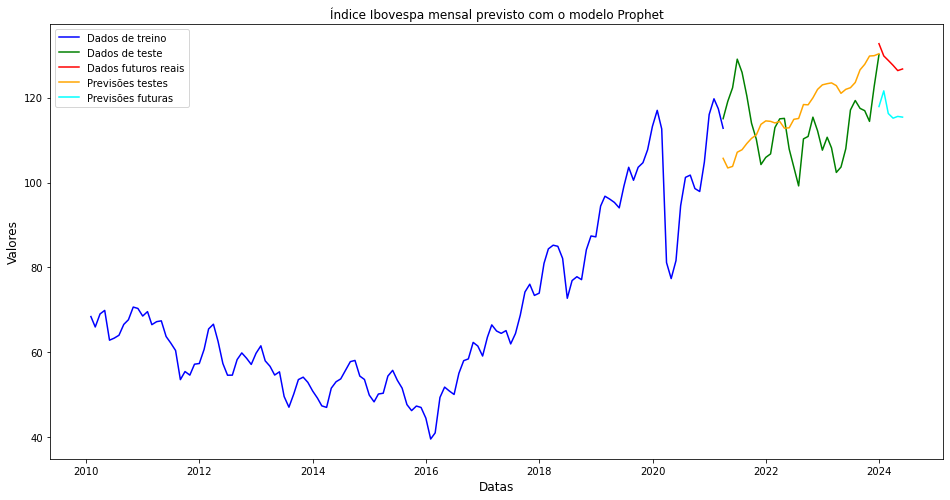

In [296]:
plt.figure(figsize=(16, 8))

plt.plot(treino_mensal['ds'], treino_mensal['y'],color='blue', label='Dados de treino')
plt.plot(teste_mensal['ds'], teste_mensal['y'],color='green', label='Dados de teste')
plt.plot(previsao_mensal['ds'], previsao_mensal['y'],color='red', label='Dados futuros reais')
plt.plot(teste_mensal['ds'],best_prediction2['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao_mensal['ds'],predicao['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

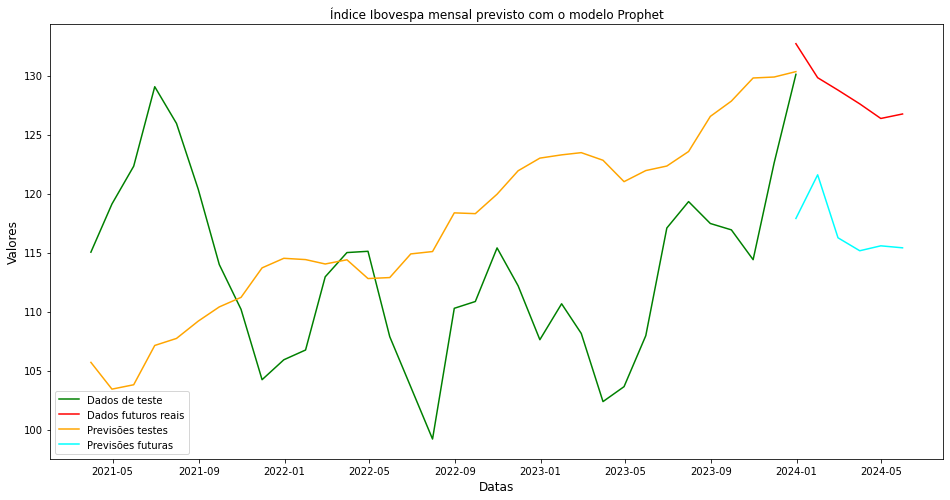

In [297]:
plt.figure(figsize=(16, 8))

#plt.plot(treino_mensal['ds'], treino_mensal['y'],color='blue', label='Dados de treino')
plt.plot(teste_mensal['ds'], teste_mensal['y'],color='green', label='Dados de teste')
plt.plot(previsao_mensal['ds'], previsao_mensal['y'],color='red', label='Dados futuros reais')
plt.plot(teste_mensal['ds'],best_prediction2['yhat'],color='orange', label='Previsões testes')
plt.plot(previsao_mensal['ds'],predicao['yhat'],color='cyan', label='Previsões futuras')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [298]:
print('RMSE:',RMSE)
print('MAE:',MAE)
print('MAPE:',MAPE)

RMSE: 11.854215360971658
MAE: 11.685167049151998
MAPE: 0.09074126586103765
